# Compare double wake results in all cases

Expand comparison to all single wakes occuring in aligned simulations across 8-9 m/s

In [1]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import pickle
from scipy.optimize import minimize

## Load FLORIS models and SOWFA DATA

In [2]:
df = pickle.load( open( "sowfa_04.p", "rb" ) )
# fi_dict = pickle.load( open( "floris_models_2.p", "rb" ) ) # Before retuning TI
fi_dict = pickle.load( open( "floris_models_3.p", "rb" ) ) # After retuning TI in a_08
fi_dict

{'g': (<floris.tools.floris_interface.FlorisInterface at 0x10fee87d0>,
  'b',
  's',
  'gauss'),
 'gt': (<floris.tools.floris_interface.FlorisInterface at 0x121ba5810>,
  'r',
  'd',
  'gauss_tune'),
 'gch': (<floris.tools.floris_interface.FlorisInterface at 0x121bbc090>,
  'g',
  'o',
  'gch_paper'),
 'leg': (<floris.tools.floris_interface.FlorisInterface at 0x121bc1210>,
  'gray',
  '^',
  'legacy'),
 'def': (<floris.tools.floris_interface.FlorisInterface at 0x121bc6390>,
  'orange',
  '*',
  'default')}

In [3]:
# # Add one more case, gch_tune + jen's TI tuning
# (fi_tune, floris_color, floris_marker, floris_label) = fi_dict['gt']
# fi_tune_gch_paper = copy.deepcopy(fi_tune)
# model_params = fi_tune_gch_paper.get_model_parameters()
# (fi_gch, floris_color, floris_marker, floris_label) = fi_dict['gch']
# model_params_gch = fi_gch.get_model_parameters()
# model_params['Wake Turbulence Parameters'] = model_params_gch['Wake Turbulence Parameters']
# fi_tune_gch_paper.set_model_parameters(model_params,verbose=True)
# fi_dict['tune_plus_jen_ti'] = (fi_tune_gch_paper, 'm', '*', 'tune+jen_ti')

In [4]:
# # Add one more case, gauss_tune + tunings from a_08 script
# (fi_tune, floris_color, floris_marker, floris_label) = fi_dict['gt']
# fi_tune_new_tune = copy.deepcopy(fi_tune)
# model_params = fi_tune_new_tune.get_model_parameters()

# x = [0.5     ,   0.5     ,   0.55624399, 1.28887181]

# model_params['Wake Turbulence Parameters']['ti_initial'] = x[0] * 0.1 # how much to scale inital by
# model_params['Wake Turbulence Parameters']['ti_constant'] = x[1] * 0.73 # how much to scale inital by
# model_params['Wake Turbulence Parameters']['ti_ai'] = x[2] * 0.8 # how much to scale inital by
# model_params['Wake Turbulence Parameters']['ti_downstream'] = x[3] * -0.275 # how much to scale inital by

# fi_tune_new_tune.set_model_parameters(model_params,verbose=True)
# fi_dict['tune_plus_new_tune'] = (fi_tune_new_tune, 'm', '*', 'tune_new_tune')

In [5]:
# Make a color dict
color_dict = dict()
for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    color_dict[floris_label] = floris_color

## Limit DF to tuning cases

In [6]:
print(df.shape)

(768, 22)


In [7]:
# Limit to aligned only
df = df[df.yaw.apply(lambda x: np.max(np.abs(x)))==0.0]

In [8]:
# Limit to 8 m/s (or not, comment out)
df = df[df.sowfa_U0<9]
df.shape

(80, 22)

In [9]:
# Get the single wake results in all simulations
results_df = pd.DataFrame()

for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]

    # Set up FLORIS to match
    # Determine free-stream wind speed column
    freestream_name = 'freestream_' + floris_label
    
    if freestream_name == 'freestream_tune+jen_ti':
        freestream_name = 'freestream_gauss_tune'
        
    if freestream_name == 'freestream_tune_new_tune':
        freestream_name = 'freestream_gauss_tune'

    
    for i, row in df.iterrows():


        # Match the layout
        if (floris_label == 'gch_paper') or (floris_label == 'legacy') :
                fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                               wind_speed=[row[freestream_name]],
                              turbulence_intensity=[row.floris_TI])
        else:
            fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                       wind_speed=[row[freestream_name]],
                                      turbulence_intensity=[row.freestream_ti])

        fi.calculate_wake()

        floris_power = np.array(fi.get_turbine_power())/1000.

        # Now sort out the powers by wakes
        upstream_idx = np.where(row.wake_table==0)
        sowfa_upstream_power = np.mean(row.power[upstream_idx])
        floris_upstream_power = np.mean(floris_power[upstream_idx])

        mult_wake_indices = np.where(row.wake_table>1)
        for idx in mult_wake_indices[0]:
            sowfa_downstream_power = np.mean(row.power[idx])
            floris_downstream_power = np.mean(floris_power[idx])
            # print(idx,row.wake_table)
            # Make a dictionary entry for this row
            result_dict = {'sowfa_upstream_power':[sowfa_upstream_power],
                           'sowfa_downstream_power':[sowfa_downstream_power],
                           'floris_upstream_power':[floris_upstream_power],
                           'floris_downstream_power':[floris_downstream_power],
                           'sowfa_wake_loss':[sowfa_upstream_power - sowfa_downstream_power],
                           'floris_wake_loss':[floris_upstream_power - floris_downstream_power],
                           'floris_label':[floris_label],
                           'sowfa_U0':row.sowfa_U0,
                           'sowfa_TI':row.sowfa_TI,
                           'num_wakes':row.wake_table[idx]
                          }
            # temp_df = 
            results_df = results_df.append(pd.DataFrame(result_dict))
    
results_df.head()

,sowfa_upstream_power,sowfa_downstream_power,floris_upstream_power,floris_downstream_power,sowfa_wake_loss,floris_wake_loss,floris_label,sowfa_U0,sowfa_TI,num_wakes
0,1936.0,637.4,1935.827479,787.157143,1298.6,1148.670337,gauss,8.0,0.1,2
0,1936.2,787.2,1936.028454,1057.365617,1149.0,878.662837,gauss,8.0,0.1,2
0,1936.5,1249.3,1936.329941,1372.935948,687.2,563.393994,gauss,8.0,0.1,2
0,1936.5,945.4,1936.329941,874.693153,991.1,1061.636789,gauss,8.0,0.1,2
0,1936.6,737.1,1936.430444,747.757925,1199.5,1188.672519,gauss,8.0,0.1,2


## How do things compare?

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


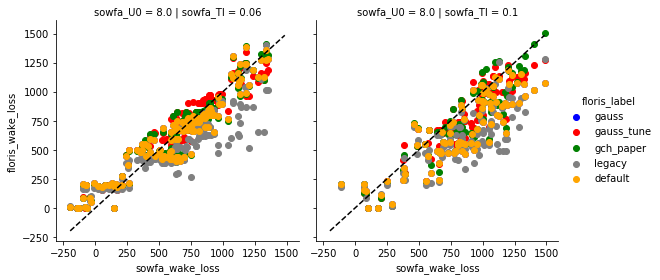

In [10]:
g = sns.FacetGrid(results_df,row='sowfa_U0', col='sowfa_TI',hue='floris_label',size=4,palette=color_dict)
g.map(plt.scatter,'sowfa_wake_loss','floris_wake_loss')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],'k--')
g.add_legend()

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


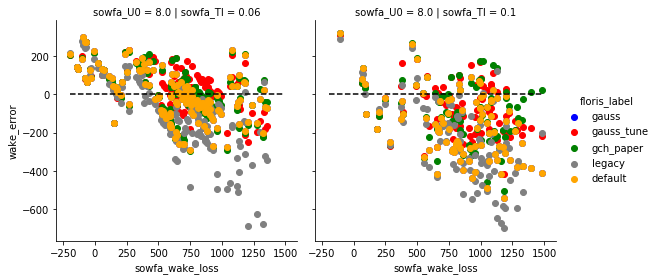

In [11]:
results_df['wake_error'] = results_df.floris_wake_loss - results_df.sowfa_wake_loss
g = sns.FacetGrid(results_df,row='sowfa_U0', col='sowfa_TI',hue='floris_label',size=4,palette=color_dict)
g.map(plt.scatter,'sowfa_wake_loss','wake_error')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [0,0],'k--')
g.add_legend()

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


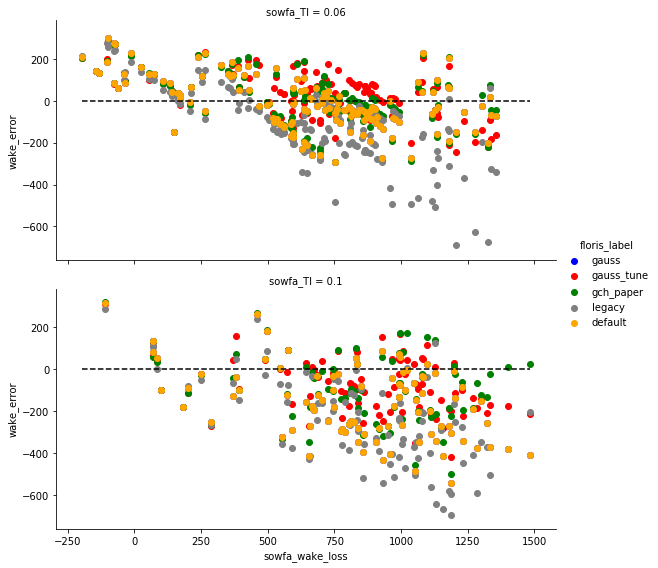

In [12]:
results_df['wake_error'] = results_df.floris_wake_loss - results_df.sowfa_wake_loss
g = sns.FacetGrid(results_df,row='sowfa_TI',hue='floris_label',size=4,aspect=2,palette=color_dict)
g.map(plt.scatter,'sowfa_wake_loss','wake_error')
for ax in g.axes.flatten():
    ax.plot([results_df.sowfa_wake_loss.min(),results_df.sowfa_wake_loss.max()],
            [0,0],'k--')
g.add_legend()

In [13]:
# Check for an overall bias and rms
results_df[['wake_error','floris_label']].groupby('floris_label').agg([np.mean,np.median,lambda x: np.sqrt(np.sum(x**2)/len(x))])

wake_error                        
                    mean      median    <lambda>
floris_label                                    
default       -71.180947  -56.204129  175.334058
gauss         -71.180947  -56.204129  175.334058
gauss_tune     -3.605993   10.720205  129.426688
gch_paper     -34.039725  -28.355948  145.729399
legacy       -172.380745 -162.537992  262.095650

My impression is the better points to the rotor are intrinsically better for multiple wakes, but a rutuning of the TI parameters could help

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


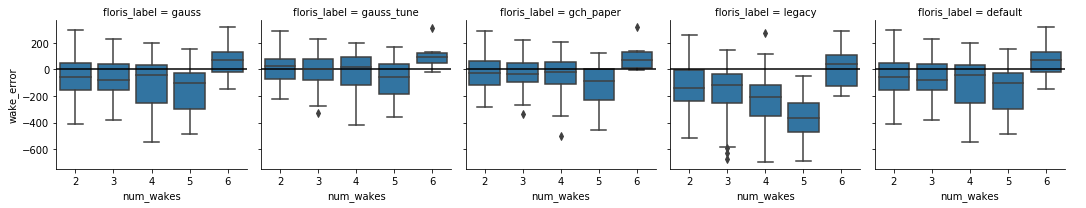

In [14]:
# error_columns = [c for c in df.columns if 'error' in c]
# df_sub = df[error_columns + ['d_spacing']]
# df_sub = pd.melt(df_sub,id_vars='d_spacing')
g = sns.FacetGrid(results_df,col='floris_label',aspect=1)
g.map(sns.boxplot,'num_wakes','wake_error')
for ax in g.axes.flatten():
    ax.axhline(0,color='k')
g.add_legend()